# notebooks.parameterized_grover_state_preparation_1d

In [ ]:
import os
os.chdir('generative_models_via_sqsp')

In [ ]:
from utilities.grover_state_preparation import *
from utilities.auxiliaries import *
from config import *

In [ ]:
import numpy as np
from scipy.stats import beta, chisquare, entropy, wasserstein_distance
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit import transpile

In [ ]:
alpha = 2
beta_ = 2
a = 0
b = 1
idx_thetas_to_optimize = [2**m-2]

In [ ]:
p_i_set = beta.pdf(np.linspace(a, b, 2**m), alpha, beta_)
p_i_set /= p_i_set.sum()

In [ ]:
thetas_to_optimize = np.array(generate_parameters(len(idx_thetas_to_optimize), k=2))
thetas = get_grover_angles(p_i_set, m)

In [ ]:
loss = []
extra_angles = []
samples_all = []
loss_history = []
best_loss = float('inf')
best_thetas = None
best_distribution = None
for run in range(runs):
    result = minimize(objective_function, thetas_to_optimize,
                      args=(idx_thetas_to_optimize, thetas, p_i_set, shots),
                      method=optimizer_type, options={"disp": False, "maxiter": max_iterations})
    current_loss = result.fun
    thetas_to_optimize = result.x
    loss_history.append(current_loss)
    if current_loss < best_loss:
        best_loss = current_loss
        best_thetas = np.array(thetas.copy())
        best_thetas[idx_thetas_to_optimize] = thetas_to_optimize

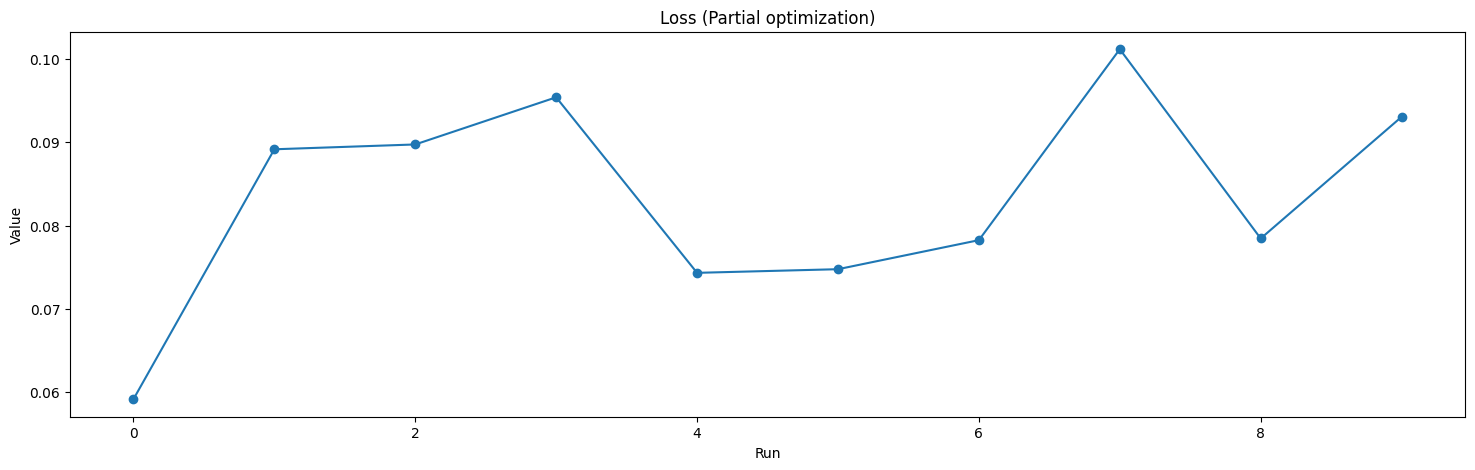

In [ ]:
plt.figure(figsize=(18, 5))
plt.plot(loss_history, marker='o', linestyle='-')
plt.xlabel("Run")
plt.ylabel("Value")
plt.title("Loss (Partial optimization)")
plt.show()

In [ ]:
qc = state_expansion(m, best_thetas)
t_qc = transpile(qc, backend=backend)
job = backend.run(t_qc, shots=shots)
counts = job.result().get_counts(qc)
samples = np.array([counts.get(state, 0) for state in all_states], dtype=float)
samples /= samples.sum()
emd = wasserstein_distance(samples, p_i_set)
print(f"Earth Mover's Distance: {emd}")

Earth Mover's Distance: 0.0074264179830586035


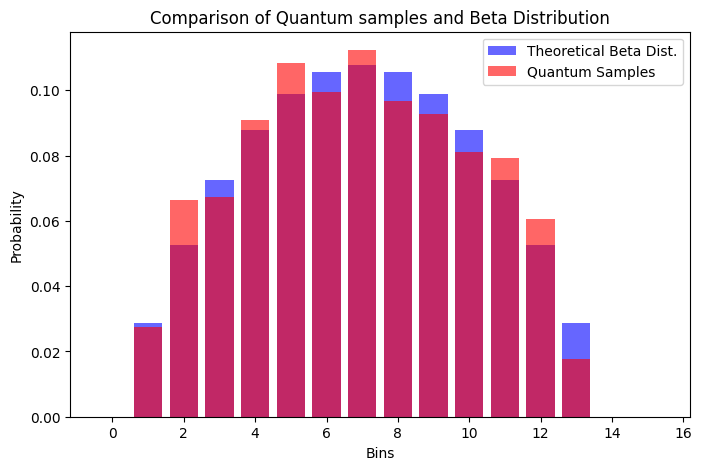

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(range(len(p_i_set)), p_i_set, alpha=0.6, label='Theoretical Beta Dist.', color='blue')
plt.bar(range(len(samples)), samples, alpha=0.6, label='Quantum Samples', color='red')
plt.xlabel("Bins")
plt.ylabel("Probability")
plt.legend()
plt.title("Comparison of Quantum samples and Beta Distribution")
plt.show()